Twitter sentiment investing strat

1. Load Twitter Sentiment Data
Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [90]:
'''import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')
'''
#sentiment_df = pd.read_csv('sentiment_data.csv')


# twitter Sentiment score in dataframe is calculated by the methoodology of data provider

#sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

#sentiment_df = sentiment_df.set_index(['date', 'symbol'])

# many bots on twitter, so we need to measure twitter engagement instead.
# care about the number of engagements not likes. 
# engagement ratio = twitter comment / twitter likes.   Comments are people, bots are likes.

#sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / sentiment_df['twitterLikes']

#now we want to filter out stocks that have a high engagement ratio.
# and filter out stocks with low likes and low comments. 
#sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20)&(sentiment_df['twitterComments'] > 10)]
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

2. Aggregate Monthly and calculate average sentiment for the month

Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [91]:
sentiment_df = sentiment_df.drop(['ATVI'],level=1, axis=0)

In [92]:
# calculate average engagement ratio for each stock in each month
sentiment_df.reset_index('symbol')

,symbol,twitterPosts,twitterComments,twitterLikes,twitterImpressions,twitterSentiment,engagement_ratio
date,,,,,,,
2021-11-18,AAPL,811.0,2592.0,21674.0,7981808.0,NaN,0.119590
2021-11-18,AMD,150.0,675.0,2949.0,1645270.0,NaN,0.228891
2021-11-18,AMZN,557.0,1315.0,12969.0,5590695.0,NaN,0.101396
2021-11-18,BA,61.0,55.0,342.0,425847.0,NaN,0.160819
2021-11-18,CRM,25.0,7183.0,29832.0,142826.0,NaN,0.240782
...,...,...,...,...,...,...,...
2023-01-04,T,184.0,3409.0,14271.0,884935.0,0.590457,0.238876
2023-01-04,TSLA,6767.0,540711.0,3810688.0,55464921.0,0.543057,0.141893
2023-01-04,TSN,35.0,168.0,460.0,57207.0,0.561900,0.365217


In [93]:
aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
[['engagement_ratio']].mean())


/var/folders/k8/y9rb911j1nsb_jtrlxppsgtw0000gn/T/ipykernel_13656/3147725976.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])


In [95]:
aggregated_df['rank'] = (aggregated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))



aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  71.0
           TSN             0.280553  30.0
           V               0.194045  59.0
           XOM             0.217904  52.0

[1094 rows x 2 columns]

In [96]:
# select each month the top 5 stocks. graph start date to next month, calculate return in equally weighted portfolio.

filtered_df = aggregated_df[aggregated_df['rank'] <= 5].reset_index('symbol')
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])
filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

4. Extract the stocks to form portfolios with at the start of each new month

Create a dictionary containing start of month and corresponded selected stocks.

In [97]:
dates = filtered_df.index.get_level_values(0).unique()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d).index.tolist()

fixed_dates


{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [98]:
stocks_list = sentiment_df.index.get_level_values(1).unique().tolist()
stocks_list


['AAPL',
 'AMD',
 'AMZN',
 'BA',
 'CRM',
 'ES',
 'F',
 'GOOG',
 'GOOGL',
 'JPM',
 'META',
 'MNST',
 'MSFT',
 'NFLX',
 'NKE',
 'NVDA',
 'PFE',
 'TSLA',
 'ABBV',
 'ABT',
 'C',
 'CMG',
 'DIS',
 'EA',
 'EBAY',
 'FCX',
 'GS',
 'K',
 'KEY',
 'KO',
 'MA',
 'MO',
 'MU',
 'PEP',
 'STZ',
 'T',
 'TSN',
 'V',
 'PG',
 'OXY',
 'AAL',
 'DAL',
 'EL',
 'GILD',
 'J',
 'LUV',
 'PM',
 'SLB',
 'AES',
 'REGN',
 'A',
 'D',
 'ILMN',
 'L',
 'CB',
 'HBAN',
 'BIIB',
 'MRO',
 'NUE',
 'BKR',
 'DD',
 'TMO',
 'AEP',
 'ENPH',
 'AAP',
 'MRNA',
 'INTC',
 'LMT',
 'NCLH',
 'JNJ',
 'PYPL',
 'BMY',
 'CVX',
 'HON',
 'XOM',
 'DVN',
 'MPC',
 'RCL',
 'AVGO',
 'DG',
 'DLTR',
 'MDT',
 'CCL',
 'ALB']

5. Download fresh stock prices for only selected/shortlisted stocks

In [100]:
prices_df = yf.download(tickers=stocks_list, start='2021-01-01', end='2023-03-01')
prices_df

[*********************100%***********************]  84 of 84 completed


Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.796387  15.13  143.820709  126.544205   89.772621  101.576210   
2021-01-05  116.743149  15.43  143.665359  128.108749   90.700928  102.833008   
2021-01-06  119.944542  15.52  151.965179  123.796440   89.917412  102.618896   
2021-01-07  123.136147  15.38  153.263168  128.020767   90.879753  103.615013   
2021-01-08  124.014572  15.13  155.447800  129.125732   91.356682  103.903610   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.342056  15.56  138.133072  147.585373  141.040497   99.153099   
2023-02-23  141.448334  15.87  136.584579  148.070984  142.351044   99.017929   
2023-02-24  139.472778  15.56  133.545319  145.404922  142.950134   96.999916   
2023-02-27  140.440796  15.63  135.257309  146.604156  144.419754   96.333672   
2023-02-28  140.233383  15.98  139.421875  146.098709  144.064041   98.216507   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  70.264359  20.518084  146.840118  92.300003  ...  5732800   
2021-01-05  70.169586  21.206726  156.749405  92.769997  ...  4029500   
2021-01-06  70.729698  22.054287  168.457733  90.330002  ...  3612500   
2021-01-07  68.842529  21.833569  177.020157  95.160004  ...  3993700   
2021-01-08  68.230721  22.442753  177.116348  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  84.627411  23.763327  240.589996  76.610001  ...  2044600   
2023-02-23  84.524910  23.763327  247.814056  79.750000  ...  2066600   
2023-02-24  84.264008  23.697811  243.587036  78.089996  ...  2875100   
2023-02-27  83.928543  23.285997  250.908676  78.769997  ...  2459700   
2023-02-28  81.971741  23.098814  248.263107  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 504 columns]

6. Calculate Portfolio Returns with monthly rebalancing

In [102]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()  # list of all stock returns in the period

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys(): # for each month
    
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]  # dictionary values = list of stocks of the month
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    # for selected columns (stocks) calculate the mean return of the month
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df # equally weighted portfolio returns for each month in DF

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

NOTE !! ALWAYS USE SURVIVORSHIP BIAS FREE STOCK LIST WHEN RESEARCHING

In [124]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff()

qqq_ret.columns = ['nasdaq_return']
qqq_ret


portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


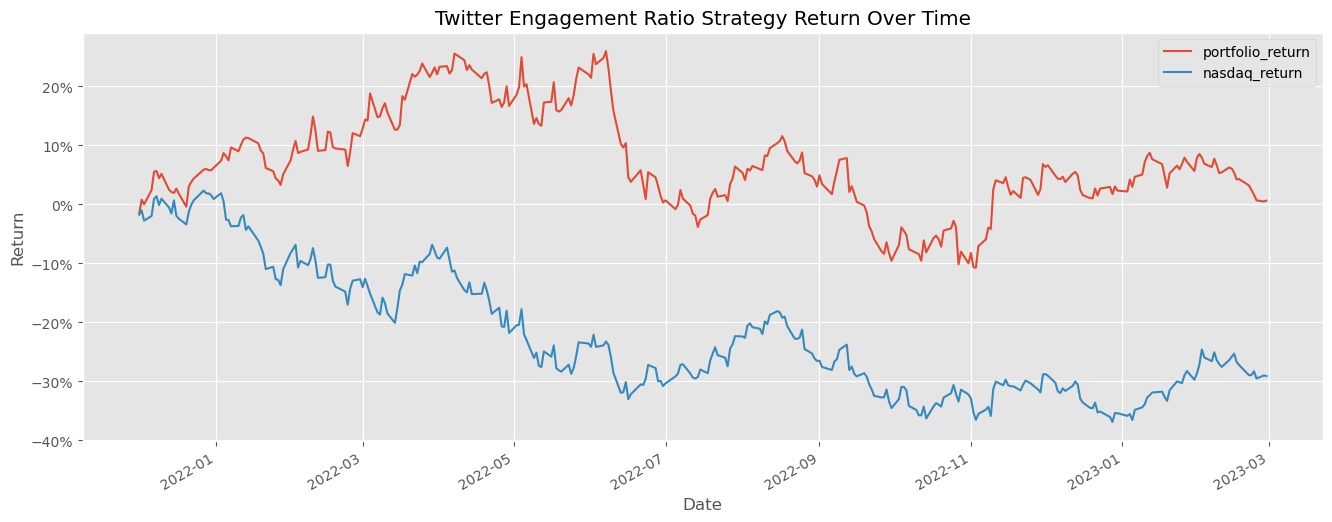

In [126]:
#visualise
import matplotlib.ticker as mtick 

portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()